## Custom forward feet network
created only with np library, visualisations using matplotlib and datasets from sklearn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

In [2]:
class NN:
    
    def __init__(self, layers, activation, loss_function, bias_init, weights_init, softmax=False):
        self.layers = layers
        self.n_layers = len(layers)
        self.n_weights = len(layers) - 1
        self.softmax = softmax

        self.loss_train = []
        self.loss_valid = []
        
        self.activations = {
            "relu": self.relu,
            "sigmoid": self.sigmoid,
            "tanh": self.tanh
        }

        self.loss_functions = {
            "mse": self.mse,
            "cross-entropy": self.cross_entropy
        }

        self.bias_inits = {
            "normal": self.random_bias,
            "zero": self.zero_bias,
        }

        self.weights_inits = {
            "normal": self.random_weights,
            "he": self.he_init,
        }

        self.activation_function = self.activations[activation]
        self.loss_function = self.loss_functions[loss_function]

        
        self.weights = self.weights_inits[weights_init](layers)
        self.biases =  self.bias_inits[bias_init](layers)
        


    # ------------------------------------- Weights & Bias initialization ------------------------------------- #

    # gettting the weights from the normal distribution
    def random_weights(self, layers):
        weights = []
        for i in range(self.n_weights):
            weights.append(np.random.randn(layers[i], layers[i + 1]))
        return weights

    def he_init(self, layers):
        weights = []
        for i in range(self.n_weights):
            # number of neurons in the layer
            fan_in = layers[i]
            # He initialization standard deviation
            std = np.sqrt(2. / fan_in)
            # Initializing weights from a normal distribution with mean=0 and std calculated by He initialization
            weights.append(std * np.random.randn(layers[i], layers[i + 1]))
        return weights
        

    # bias from the normal distribution
    def random_bias(self, layers):
        biases = []
        for i in layers[1:]:
            biases.append(np.random.randn(1, i))
        return biases

    # setting all biases to zero
    def zero_bias(self, layers):
        biases = []
        for i in layers[1:]:
            biases.append(np.zeros((1, i)))  # Initialize biases to zeros
        return biases


    # ------------------------------------- Loading and preparing data ------------------------------------- #

    # data set - array of tuples, where the first element is as input array and the second element is the desired output array
    # ratios are the ratios of train, validation and test data
    def load_data(self, X, y, ratios, categorization=False):
        if categorization:
            # one-hot encoding for the output layer - assumes indexing from 0 in the labels
            num_cols = np.max(y) + 1
            y = np.eye(num_cols)[y]
        # checking if the data matches the NN architecture - I/O
        #assert (len(X[0]) == self.layers[0]) and (len(y[0]) == self.layers[-1]), "NN structure doesn't match the data"
        assert (sum(ratios) != 1), "ratios should sum up to 1"
        idx1 = int(ratios[0] * len(X))
        idx2 = int(sum(ratios[:2]) * len(X))
        indices = np.arange(len(X))
        np.random.shuffle(indices)
        X_shuffled, y_shuffled = X[indices], y[indices]
        self.X_train = X_shuffled[:idx1]
        self.Y_train = y_shuffled[:idx1]
        self.X_valid = X_shuffled[idx1:idx2]
        self.Y_valid = y_shuffled[idx1:idx2]
        self.X_test = X_shuffled[idx2:]
        self.Y_test = y_shuffled[idx2:]

    # ------------------------------------- Training the neural network ------------------------------------- #
    
    def train_NN(self, n_epochs, batch_size, learning_rate):
        for epoch in range(n_epochs + 1):
            self.loss_train.append(self.loss_function(self.forward_pass(self.X_train), self.Y_train))
            self.loss_valid.append(self.loss_function(self.forward_pass(self.X_valid), self.Y_valid))
            for _ in range (int(len(self.X_train / batch_size))):
                # creating a minibatch on the fly
                minibatch_indexes = np.random.choice(range(0, len(self.X_train)), batch_size, replace=False)
                minibatch_X = self.X_train[minibatch_indexes]
                minibatch_Y = self.Y_train[minibatch_indexes]
                self.update_minibatch(minibatch_X, minibatch_Y, learning_rate, batch_size)
            if epoch % 100 == 0:
                self.evaluate_categorization(epoch)

    # calculating gradients for a single minibatch + updating NN parameters
    def update_minibatch(self, minibatch_X, minibatch_Y, learning_rate, batch_size):
        nabla_weights = [np.zeros(w.shape) for w in self.weights]
        nabla_biases = [np.zeros(b.shape) for b in self.biases]
        for (X,Y) in zip(minibatch_X, minibatch_Y):
            # backpropagation algorithm
            delta_nabla_weights, delta_nabla_biases = self.backpropagation(X, Y)
            # updating the nablas - adding gradients
            nabla_weights = [nw + dnw for (nw, dnw) in zip(nabla_weights, delta_nabla_weights)]
            nabla_biases = [nb + dnb for (nb, dnb) in zip(nabla_biases, delta_nabla_biases)]
        # updating the NN parameters, averiging the gradients + multiplying by the learning rate
        self.weights = [w - (learning_rate / batch_size) * delta_w for (w, delta_w) in zip(self.weights, nabla_weights)]
        self.biases = [b - (learning_rate / batch_size) * delta_b for (b, delta_b) in zip(self.biases, nabla_biases)]


    # expects input as an 1 x n  numpy array (n = neurons in input layer)
    # only for evaluation, custom input to the network
    def forward_pass(self, input):
        for i in range(self.n_weights):
            z = input @ self.weights[i] + self.biases[i]
            activation = self.activation_function(z)
            input = activation
        return input

    # backpropagation algorithm
    def backpropagation(self, x, y):
        # matrices of gradients - all zeros
        nabla_weights = [np.zeros(w.shape) for w in self.weights]
        nabla_biases = [np.zeros(b.shape) for b in self.biases]
        # storing activations and z's for each layer
        # storing the input as the first activation
        activations = [x]
        weighted_inputs = []

        # feed forward + storing all information
        for (w, b) in zip(self.weights, self.biases):
            z = x @ w + b
            x = self.activation_function(z)
            # storing weighted input + activation for further use
            weighted_inputs.append(z)
            activations.append(x)

        if self.softmax:
            exp_x = np.exp(weighted_inputs[-1] - np.max(weighted_inputs[-1]))
            activations[-1] = exp_x / exp_x.sum()

        # backward pass
        # error in the output layer
        delta = self.loss_function(activations[-1], y, derivation=True) * self.activation_function(weighted_inputs[-1], derivation=True)
        # gradient of biases = error in the corresponding layer
        nabla_biases[-1] = delta
        # gradient of weights = error in the corresponding layer dotted/weighted with activations of the previous layer
        nabla_weights[-1] = np.dot(activations[-2].T.reshape(-1, 1), delta)
        # iterating layers second to last to the second (first one won't be updated)
        for l in range(self.n_layers - 2, 0, -1):
            current_z = weighted_inputs[l - 1]
            current_z_der = self.activation_function(current_z, derivation=True)
            delta = np.dot(delta, self.weights[l].T) * current_z_der
            nabla_biases[l - 1] = delta
            nabla_weights[l - 1] = np.dot(activations[l - 1].T.reshape(-1, 1), delta)
        
        return (nabla_weights, nabla_biases)


    # ------------------------------------- Evaluation Functions ------------------------------------- #

    def evaluate(self):
        for (X, y) in zip(self.X_valid, self.Y_valid):
            y_hat = self.forward_pass(X)
            error_validation = self.loss_function(y, y_hat)
        for (X, y) in zip(self.X_train, self.Y_train):
            y_hat = self.forward_pass(X)
            error_training = self.loss_function(y, y_hat)
        print(f"train error: {error_training} | validation error: {error_validation}")

    def evaluate_categorization(self, epoch):
        y_hat = [np.argmax(self.forward_pass(X)) for X in self.X_valid] # NN assigned indexes
        correct_to_validation = np.sum(y_hat == np.argmax(self.Y_valid, axis=1)) / len(self.X_valid)
        y_hat = [np.argmax(self.forward_pass(X)) for X in self.X_train]
        correct_to_training = np.sum(y_hat == np.argmax(self.Y_train, axis=1)) / len(self.X_train)
        print(f"epoch: {epoch:5} | train error: {1 - correct_to_training:.3f} | validation error: {1 - correct_to_validation:.3f}")

    # ------------------------------------- Activation Functions ------------------------------------- #
    
    # ReLU - 0 if x < 0 else x
    def relu(self, input, derivation=False):
        if not derivation:
            return np.where(input > 0, input, 0)
        else:
            return np.where(input > 0, 1, 0)

    # Sigmoid - 1 / (1 + e^-x)
    def sigmoid(self, input, derivation=False):
        if not derivation:
            return 1 / (1 + np.exp(-input))
        else:
            return self.sigmoid(input)*(1-self.sigmoid(input))

    # Tanh - 1 - 2 / (e^2x + 1)
    def tanh(self, input, derivation=False):
        if not derivation:
            return 1 - 2 / (np.exp(2 * input) + 1)
        else:
            return 1 - self.tanh(input) ** 2
            
    
    # ------------------------------------- Loss Functions ------------------------------------- #

    # mean square error - classification loss function
    # Y - true values that SHOULD be predicted by the model
    # Y_hat - ACTUAL prediction by the model
    def mse(self, y_hat, y, derivation=False):
        if not derivation:
            return (0.5 * np.linalg.norm(y_hat - y) ** 2) / len(y_hat)
        else:
            return (y_hat - y)        


    def cross_entropy(self, y_hat, y, derivation=False):
        if not derivation:
            return (np.sum(np.nan_to_num(-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)))) / len(y_hat)
        else:
            return (y_hat - y)



    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_train, label='Training Loss')
        plt.plot(self.loss_valid, label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


        

### Iris dataset
simple dataset for classifing iris species\
*Two of the three species were collected in the Gaspé Peninsula "all from the same pasture, and picked on the same day and measured at the same time by the same person with the same apparatus".*

data = [sepal.length, sepal.width, petal.length, petal.width] all floats\
labels = {0 : Setosa, 1: Versicolour, 2: Virginica}

In [3]:
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

In [24]:
iris_nn = NN([4, 4, 3], activation="sigmoid", loss_function="cross-entropy", bias_init="zero", weights_init="he")

In [25]:
iris_nn.load_data(X_iris, y_iris, (0.7, 0.2, 0.01), categorization=True)

In [26]:
iris_nn.train_NN(200, 16, 0.3)

epoch:     0 | train error: 0.610 | validation error: 0.767
epoch:   100 | train error: 0.038 | validation error: 0.067
epoch:   200 | train error: 0.019 | validation error: 0.033


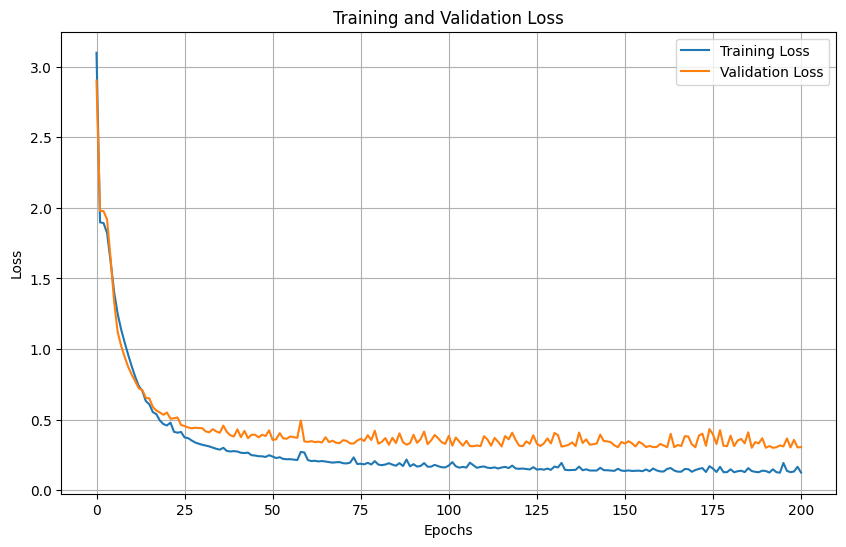

In [27]:
iris_nn.plot_loss()

### Extracting problematic values from the dataset to further research

In [28]:
problematic_vals = np.array([np.array(i) for i,j in zip(X_iris, y_iris) if j != np.argmax(iris_nn.forward_pass(i))])

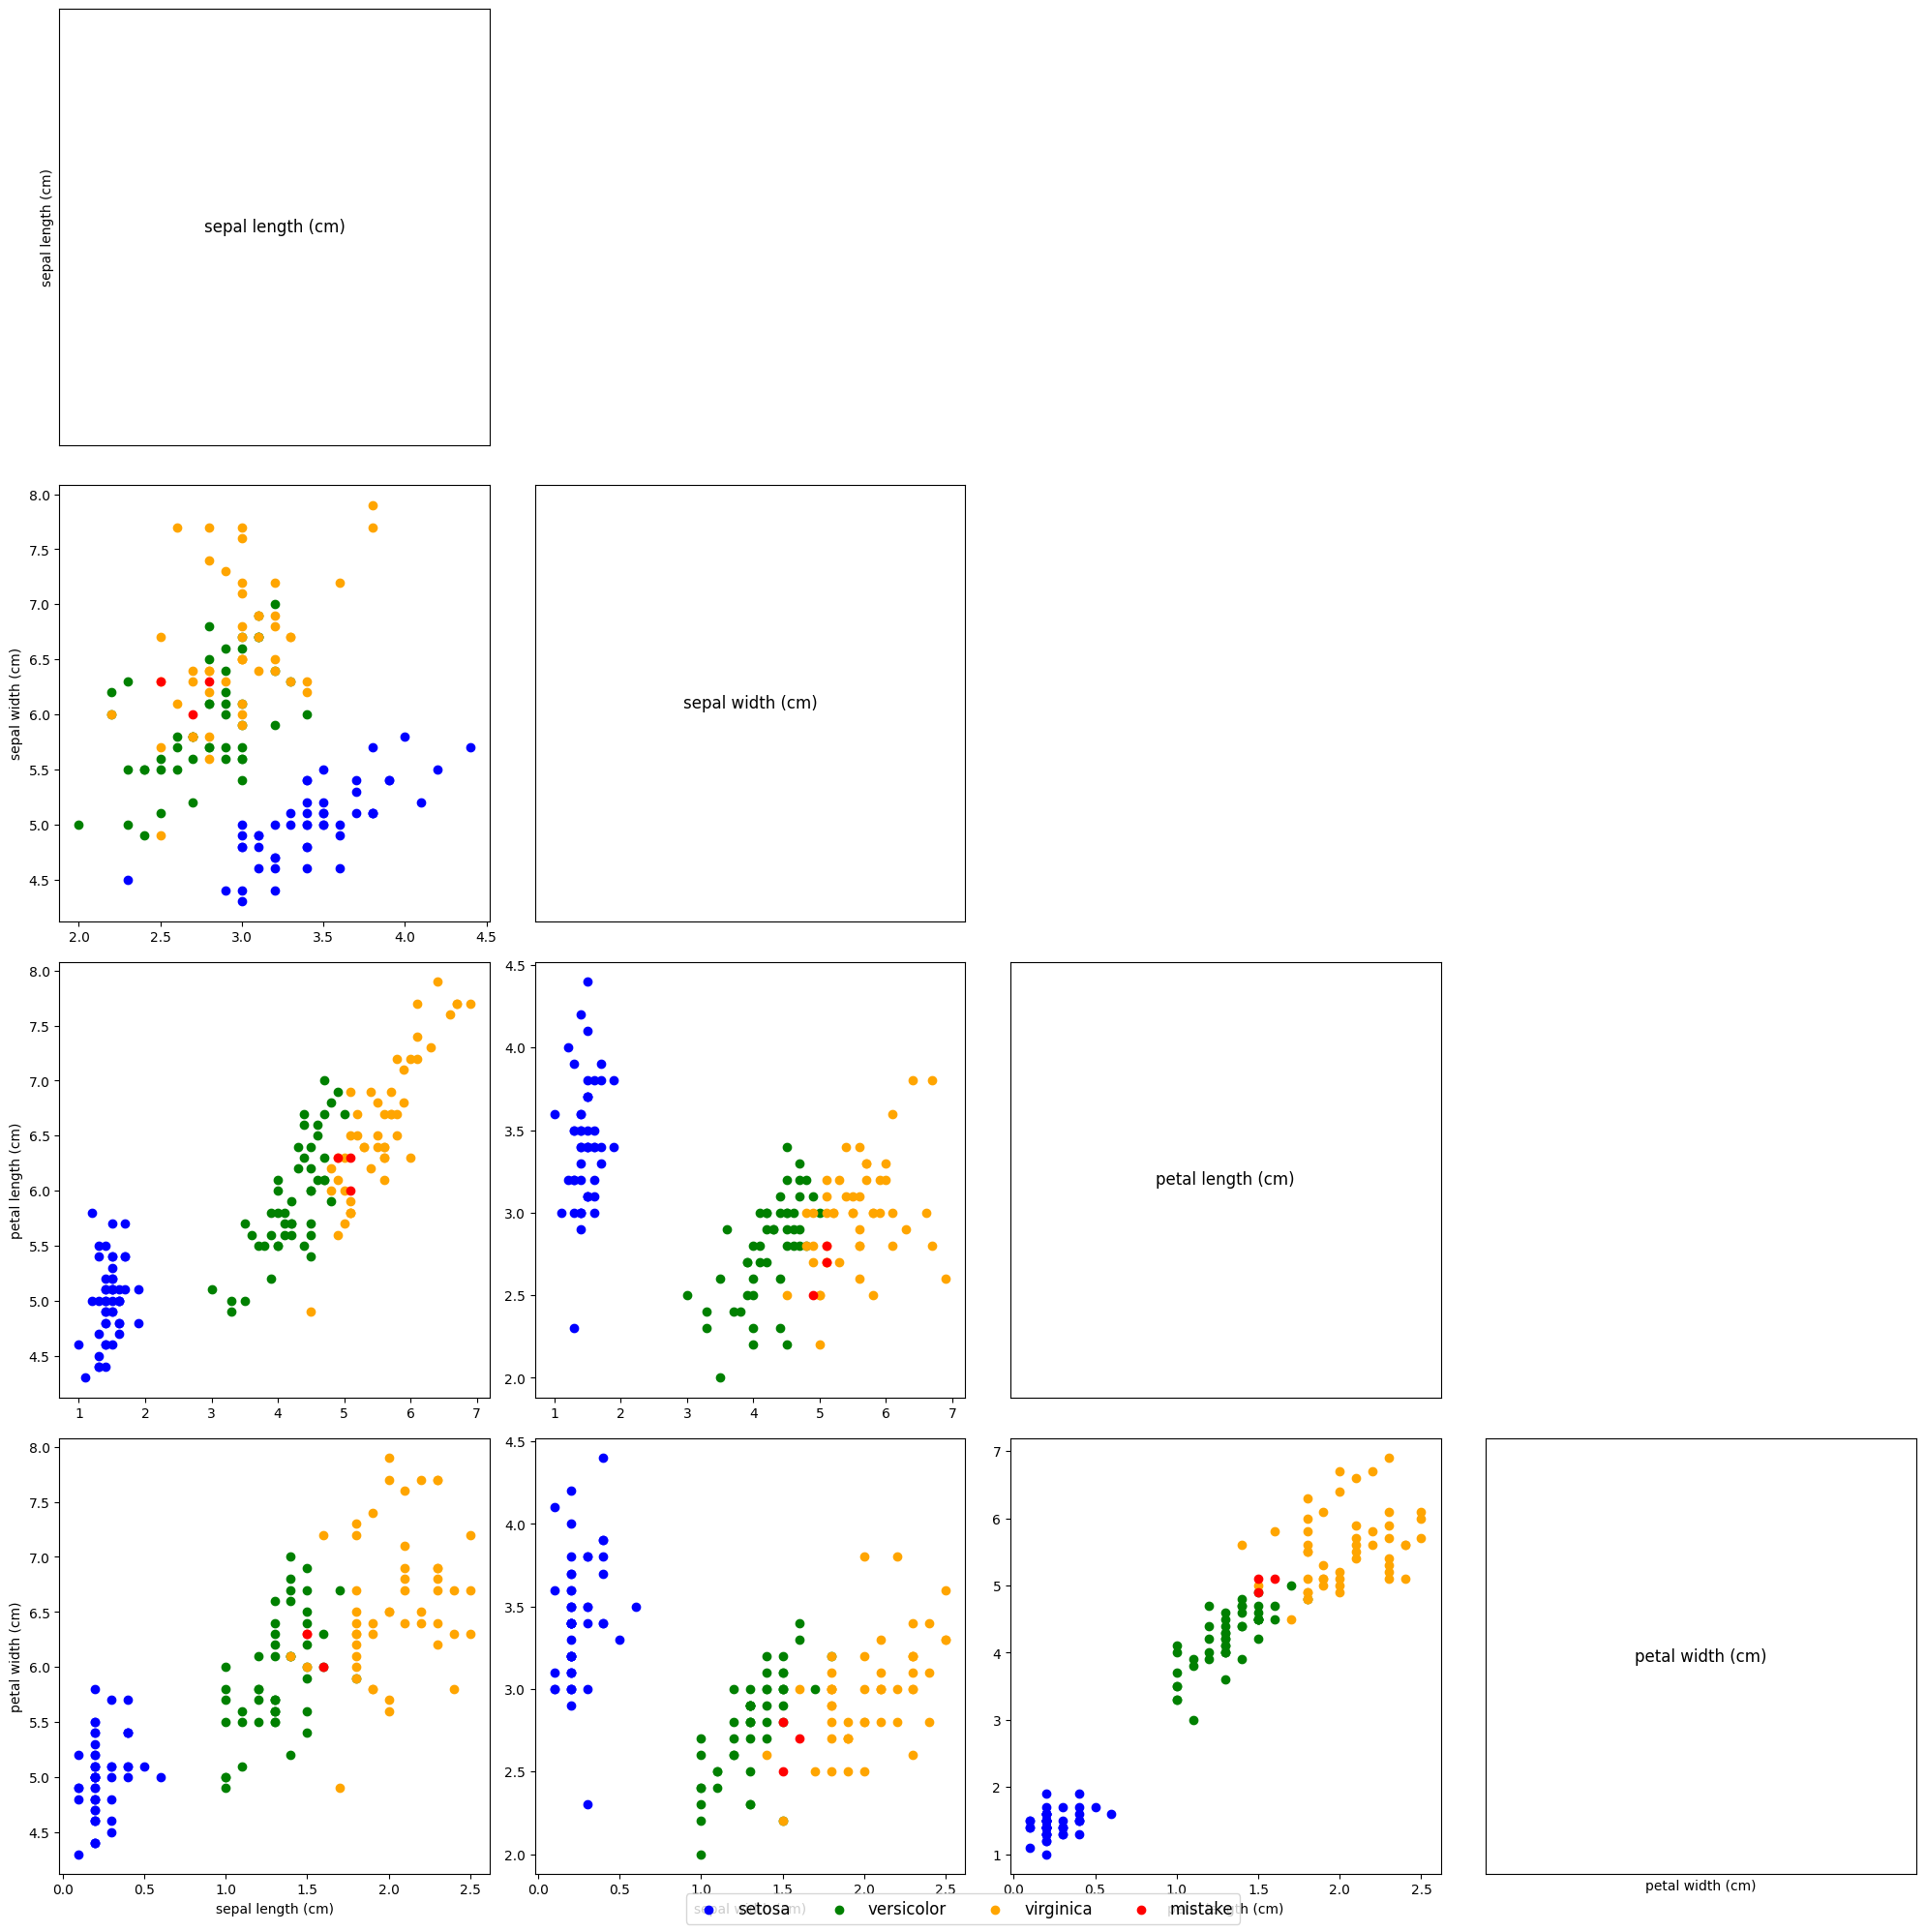

In [31]:
feature_names = iris.feature_names

# indices of datapoints incorrectly assigned by the NN
special_indices = []
for problematic in problematic_vals:
    matches = np.where((data == problematic).all(axis=1))[0]
    special_indices.extend(matches)

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

# Define custom colors for normal and special points
normal_color_map = {'setosa': 'blue', 'versicolor': 'green', 'virginica': 'orange'}

for i in range(4):
    for j in range(4):
        if i < j:
            ax[i, j].set_visible(False)  # Hide upper triangle including the diagonal
        if i == j:
            # Display the name of the feature on the diagonal
            ax[i, j].text(0.5, 0.5, feature_names[i], fontsize=12, ha='center', va='center')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
        else:
            # Normal points
            for target in set(iris.target):
                ix = np.where(iris.target == target)[0]
                ix_normal = [idx for idx in ix if idx not in special_indices]
                ax[i, j].scatter(data[ix_normal, i], data[ix_normal, j], 
                                 color=normal_color_map[iris.target_names[target]], 
                                 label=iris.target_names[target] if (i, j) == (3, 0) else "", zorder=1)
            # Special points, plotted red and on top
            ax[i, j].scatter(data[special_indices, i], data[special_indices, j], color='red', label='mistake' if (i, j) == (3, 0) else "", zorder=2)

        if i == 3:
            ax[i, j].set_xlabel(feature_names[j])
        if j == 0:
            ax[i, j].set_ylabel(feature_names[i])

# Add a legend to the last subplot in the first column, as an example
handles, labels = ax[3, 0].get_legend_handles_labels()
# Create a legend for the whole figure
fig.legend(handles, labels, loc='lower center', ncol=4, fontsize='large')

plt.tight_layout()
plt.show()





In [32]:
problematic_vals

array([[6.3, 2.5, 4.9, 1.5],
       [6. , 2.7, 5.1, 1.6],
       [6.3, 2.8, 5.1, 1.5]])